# SQUID: $I$-$V$ characteristics
Thomas D. Schanzer  
July 2022

In [618]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.odr import RealData, ODR, Model

matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'

## Overall I-V plot

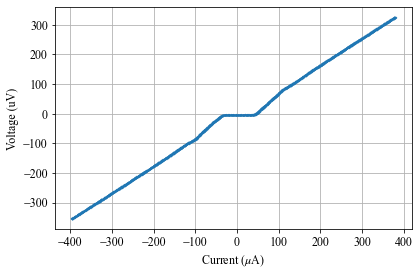

In [692]:
current, voltage = np.loadtxt(
    '../data/21072022/IV_wide_21072022_0.csv', delimiter=',', skiprows=1,
).T

fig, ax = plt.subplots()
ax.plot(current, voltage, '.', markersize=0.5)
ax.set(xlabel='Current ($\mu$A)', ylabel='Voltage (uV)')
ax.grid()
fig.tight_layout()

## Estimating uncertainties in $V$ and $I$

To estimate the $I$ uncertainty, we fit a linear spline to the triangular
current waveform and examine the residuals of the fit. This leads to
$\Delta I \sim 1$ uA.

To estimate $\Delta V$, we examine the superconducting region of the $I$-$V$
curve, where $V$ should be constant, and observe a deviation of up to 1 uV.

In [693]:
spline = UnivariateSpline(np.arange(current.size), current, k=1, s=5e4)
knots = np.int64(spline.get_knots())
fit = spline(np.arange(current.size))
residuals = current - fit

In [682]:
def add_number(ax, text):
    ax.text(
        0.05, 0.87, text, transform=ax.transAxes, fontsize=16,
        fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
    )

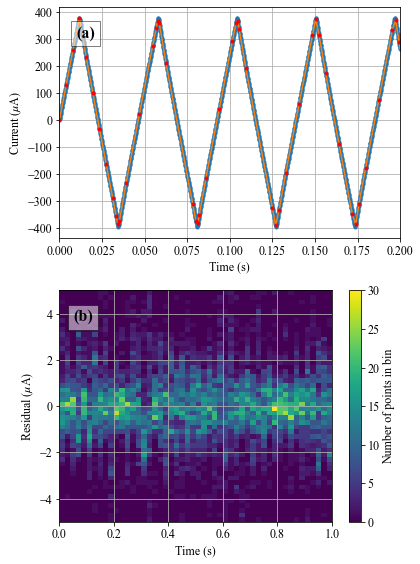

In [694]:
fig, axes = plt.subplots(2, 1, figsize=(6,8))
axes[0].plot(np.arange(current.size)*1e-4, current, '.')
axes[0].plot(np.arange(current.size)*1e-4, fit)
axes[0].plot(knots*1e-4, fit[knots], 'r.')
axes[0].set_xlim(0, 2000e-4)
add_number(axes[0], '(a)')
axes[0].set(xlabel='Time (s)', ylabel='Current ($\mu$A)')
axes[0].grid()

_, _, _, im = axes[1].hist2d(
    np.arange(current.size)*1e-4, residuals, bins=50, range=[[0, 1], [-5, 5]],
)
fig.colorbar(im, ax=axes[1], label='Number of points in bin')
add_number(axes[1], '(b)')
axes[1].set(xlabel='Time (s)', ylabel='Residual ($\mu$A)')
axes[1].grid()

fig.tight_layout()
fig.savefig('../figures/I_uncertainties.pdf', bbox_inches='tight')

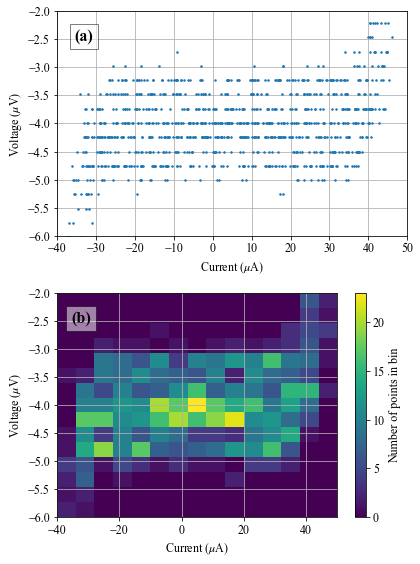

In [696]:
fig, axes = plt.subplots(2, 1, figsize=(6,8))
axes[0].plot(current, voltage, '.', markersize=3)
axes[0].set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
axes[0].grid()
axes[0].set_xlim(-40, 50)
axes[0].set_ylim(-6, -2)
add_number(axes[0], '(a)')

_, _, _, im = axes[1].hist2d(
    current, voltage, range=[[-40, 50], [-6, -2]], bins=15
)
fig.colorbar(im, ax=axes[1], label='Number of points in bin')
axes[1].set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
axes[1].grid()
add_number(axes[1], '(b)')

fig.tight_layout()
fig.savefig('../figures/V_uncertainties.pdf', bbox_inches='tight')

Use appendix for extra figures!!!

## Critical current and flux offset dependence

In [701]:
def hyperbola_plus(x, m1, b1, m2, b2, c):
    m1 = 0
    return 0.5*(
        b1 + b2 + (m1 + m2)*x
        + np.sqrt((b1 - b2 + (m1 - m2)*x)**2 + 4*c)
    )

hyperbola_plus_model = Model(lambda beta, x: hyperbola_plus(x, *beta))

def hyperbola_minus(x, m1, b1, m2, b2, c):
    m1 = 0
    return 0.5*(
        b1 + b2 + (m1 + m2)*x
        - np.sqrt((b1 - b2 + (m1 - m2)*x)**2 + 4*c)
    )

hyperbola_minus_model = Model(lambda beta, x: hyperbola_minus(x, *beta))

def linear(x, m, b):
    return m*x + b

def fit_params(file, model, limits, beta0):
    current, voltage = np.loadtxt(file, delimiter=',', skiprows=1).T
    idx = np.argsort(current)
    current = current[idx]
    voltage = voltage[idx]
    
    left, right = np.searchsorted(current, limits)
    data = RealData(current[left:right], voltage[left:right], sx=1, sy=1)

    output = ODR(data, model, beta0=beta0).run()
    params, d_params = output.beta, output.sd_beta

    return current[left:right], voltage[left:right], params, d_params

def eval_fit(current, voltage, params, func):
    fit = func(current, *params)
    fit_asym1 = linear(current, *params[0:2])
    fit_asym2 = linear(current, *params[2:4])
    residuals = voltage - fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((voltage - voltage.mean())**2)
    r_squared = 1 - ss_res/ss_tot
    return fit, residuals, r_squared, fit_asym1, fit_asym2

def critical_current_oneside(params, d_params):
    m1, b1, m2, b2 = params[:-1]
    dm1, db1, dm2, db2 = d_params[:-1]
    current_crit = 0.5*np.abs((b2 - b1)/(m2 - m1))
    d_current_crit = 0.5*(
        (db1 + db2)/np.abs(m2 - m1)
        + np.abs(b2 - b1)*(dm1 + dm2)/(m2 - m1)**2
    )
    return current_crit, d_current_crit

def critical_current(file, limits_l, limits_r, beta0_l, beta0_r):
    _, _, params, d_params = fit_params(
        file, hyperbola_minus_model, limits_l, beta0_l)
    cl, d_cl = critical_current_oneside(params, d_params)
    _, _, params, d_params = fit_params(
        file, hyperbola_plus_model, limits_r, beta0_r)
    cr, d_cr = critical_current_oneside(params, d_params)
    return np.mean([cl, cr]), np.mean([d_cl, d_cr])

def plot(ax1, ax2, file, side, limits, beta0):
    if side == 'left':
        model, func = hyperbola_minus_model, hyperbola_minus
    else:
        model, func = hyperbola_plus_model, hyperbola_plus
    
    current, voltage, params, d_params = fit_params(
        file, model, limits, beta0)
    fit, residuals, r_squared, fit_asym1, fit_asym2 = eval_fit(
        current, voltage, params, func)
    current_crit, d_current_crit = critical_current_oneside(params, d_params)
    
    # ax1.errorbar(
    #     current, voltage, xerr=1, yerr=1,
    #     marker='.', linestyle='', elinewidth=0.5, capsize=1.5, markersize=1.5,
    #     label='Data')
    ax1.plot(current, voltage, '.', markersize=4,
             label='Data ($\pm$ 1 $\mu$A, $\pm$ 1 $\mu$V)')
    ax1.plot(
        current, fit_asym1, '--', color='k', linewidth=2,
        label='Asymptotes')
    ax1.plot(current, fit_asym2, '--', color='k', linewidth=2)
    ax1.plot(
        current, fit, color='tab:orange', linewidth=1.5,
        label='Hyperbolic ODR fit')
    ax1.set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
    ax1.grid()
    title = (
        '$2I_c = ({:.0f} \\pm {:.0f})$ $\mu$A,    $R^2 = {:.2f}$'
    ).format(current_crit*2, d_current_crit*2, r_squared1)
    ax1.set_title(title)
    ax1.legend()
    
    ax2.plot(
        current, residuals, '.')
    ax2.set(xlabel='Current ($\mu$A)', ylabel='Residuals ($\mu$V)')
    ax2.axhline(0, color='tab:orange')
    ax2.grid()

In [619]:
# map file numbers to corresponding bias current setting
mapping = dict(zip(np.arange(1, 22), np.arange(0., 210., 10.)))
flux_current = np.vectorize(lambda i: mapping[i])

In [590]:
m = 0

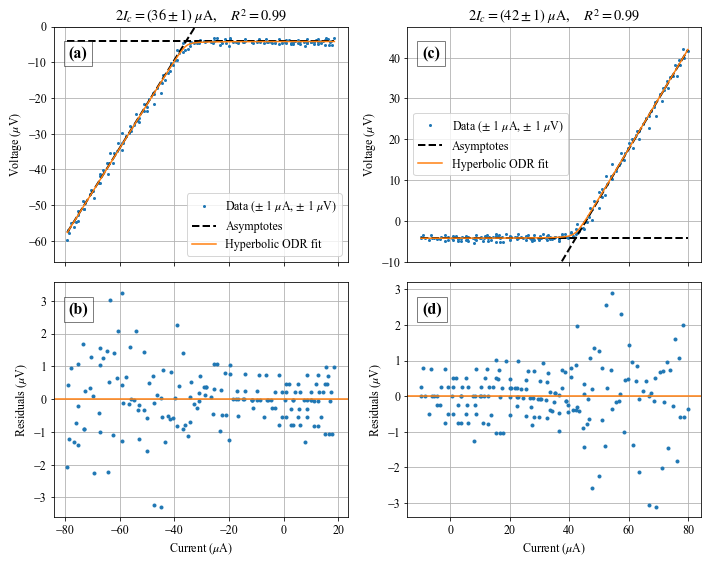

In [702]:
m = 5
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharex='col')

plot(
    *axes[:,0], f'../data/21072022/IV_narrow_21072022_{m}.csv',
    'left', (-80, 20), (0, -5, 1.2, 40, 1)
)
axes[0,0].set_ylim(top=0)
axes[0,0].set_xlabel('')
add_number(axes[0,0], '(a)')
add_number(axes[1,0], '(b)')

plot(
    *axes[:,1], f'../data/21072022/IV_narrow_21072022_{m}.csv',
    'right', (-10, 80), (0, -5, 1.2, -60, 1)
)
axes[0,1].set_ylim(bottom=-10)
axes[0,1].set_xlabel('')
axes[0,1].legend(loc='center left')
add_number(axes[0,1], '(c)')
add_number(axes[1,1], '(d)')

fig.tight_layout()
fig.savefig('../figures/knee_fits.pdf', bbox_inches='tight')

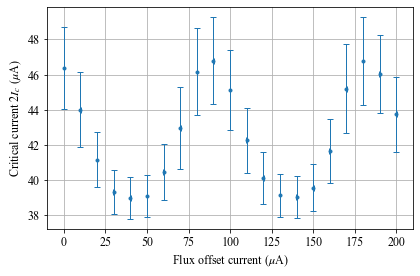

In [669]:
limits_l = (-80, 20)
limits_r = (-10, 80)
beta0_l = (0, -5, 1.2, 40, 1)
beta0_r = (0, -5, 1.2, -60, 1)
i_crit, d_i_crit = np.zeros(21), np.zeros(21)
for i in range(21):
    i_crit[i], d_i_crit[i] = critical_current(
        f'../data/21072022/IV_narrow_21072022_{i+1}.csv',
        limits_l, limits_r, beta0_l, beta0_r
    )
    
fig, ax = plt.subplots()
ax.errorbar(
    flux_current(range(1, 22)), 2*i_crit, xerr=0.2, yerr=2*d_i_crit,
    marker='.', linestyle='', elinewidth=1, capsize=3)
ax.grid()
ax.set(xlabel='Flux offset current ($\mu$A)',
       ylabel='Critical current $2I_c$ ($\mu$A)')
fig.tight_layout()
fig.savefig('../figures/Ic_vs_flux.pdf', bbox_inches='tight')

In [697]:
2*i_crit[5]

39.1016115601666

In [698]:
2*d_i_crit[5]

1.189096034690901

## Normal resistance

In [684]:
df = pd.read_csv('../data/21072022/IV_wide_21072022_0.csv')
current = df['0_x'].to_numpy()
voltage = df['0_y'].to_numpy()
idx = np.argsort(current)
current = current[idx]
voltage = voltage[idx]

In [685]:
_, _, params, d_params = fit_params(
    '../data/21072022/IV_wide_21072022_0.csv', hyperbola_minus_model,
    (-80, 20), (0, -5, 1.2, 40, 1),
)
current_crit1, _ = critical_current_oneside(params, d_params)
_, _, params, d_params = fit_params(
    '../data/21072022/IV_wide_21072022_0.csv', hyperbola_plus_model,
    (-10, 80), (0, -5, 1.2, -60, 1),
)
current_crit2, _ = critical_current_oneside(params, d_params)

In [686]:
spline = UnivariateSpline(current, voltage, k=3, s=2.7e4)
knots = spline.get_knots()
fit = spline(current)
residuals = voltage - fit

offset = (2*current_crit2 - 2*current_crit1)/2
max_width = np.minimum(current.max() - offset, offset - current.min())
width = np.linspace(100, max_width, 100)
resistance_spline = (spline(offset + width) - spline(offset - width))/(2*width)

left_idx = np.searchsorted(current, offset - width)
right_idx = np.searchsorted(current, offset + width)
width_real = (current[right_idx] - current[left_idx])/2
d_width_real = 1
resistance_real = (voltage[right_idx] - voltage[left_idx])/(2*width_real)
d_resistance_real = (
    2/(2*width_real)
    + (voltage[right_idx] - voltage[left_idx])
        * 2*d_width_real/(2*(width_real))**2
)

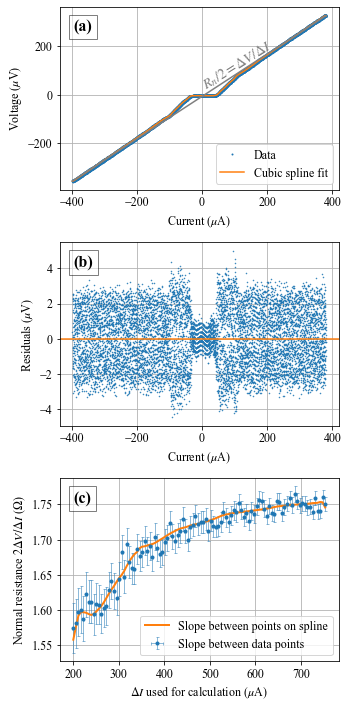

In [689]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))

ax1.plot(current, voltage, '.', markersize=2, label='Data')
ax1.plot(current, fit, label='Cubic spline fit')
ax1.plot([current[0], current[-1]], [voltage[0], voltage[-1]], color='gray')
ax1.text(
    0.5, 0.55, '$R_n/2 = \Delta V/\Delta I$', fontsize=14,
    transform=ax1.transAxes, color='gray', rotation=32
)
ax1.set(xlabel='Current ($\mu$A)', ylabel='Voltage ($\mu$V)')
ax1.legend(loc='lower right')
ax1.grid()
ax1.text(
    0.05, 0.87, '(a)', transform=ax1.transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

ax2.plot(current, residuals, '.', markersize=1)
ax2.axhline(0, color='tab:orange')
ax2.set(xlabel='Current ($\mu$A)', ylabel='Residuals ($\mu$V)')
ax2.grid()
ax2.text(
    0.05, 0.87, '(b)', transform=ax2.transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

ax3.errorbar(
    2*width_real, 2*resistance_real,
    xerr=2*d_width_real, yerr=2*d_resistance_real,
    marker='.', linestyle='', elinewidth=0.5, capsize=1.5, capthick=0.5,
    label='Slope between data points')
ax3.plot(
    2*width, 2*resistance_spline, linewidth=2,
    label='Slope between points on spline')
ax3.legend()
ax3.set(
    xlabel='$\Delta I$ used for calculation ($\mu$A)',
    ylabel='Normal resistance $2 \Delta V / \Delta I$ ($\Omega$)')
ax3.grid()
ax3.text(
    0.05, 0.87, '(c)', transform=ax3.transAxes, fontsize=16,
    fontweight='bold', bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 5},
)

fig.tight_layout()
fig.savefig('../figures/iv.pdf', bbox_inches='tight')

In [688]:
normal_resistance = 2*resistance_spline.max()
d_normal_resistance = 2*d_resistance_real[-10:].mean()
normal_resistance, d_normal_resistance

(1.7533889051480425, 0.010297907378833317)